In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


In [2]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

vocab_size = 64
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

pretrained_model = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))
pretrained_model.eval()

MaskedDiffusion(
  (denoising_model): MLP(
    (embedding): Embedding(65, 64)
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=64, out_features=130, bias=True)
    )
  )
)

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [3]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - ((x0 - 0.5) * 12) ** 2 / 100
    reward_x1 = - ((x1 - 0.5) * 12) ** 2 
    
    reward = (x[:, 0, :-1] * reward_x0 + x[:, 1, :-1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.  

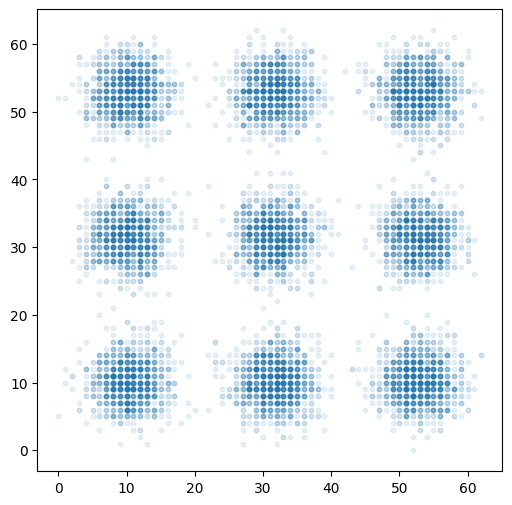

Pre-trained distribution Reward: -11.580293655395508


In [4]:
# Visualize pre-trained model samples
pretrained_model.eval()
with torch.no_grad():
    pretrained_model_samples = pretrained_model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(pretrained_model_samples[:, 0], pretrained_model_samples[:, 1], s=10, alpha=0.1)
plt.show()

rewards = compute_rewards(F.one_hot(torch.from_numpy(pretrained_model_samples), num_classes=num_categories).float())
pretrained_samples_reward = rewards.mean().item()
print(f"Pre-trained distribution Reward: {pretrained_samples_reward}")

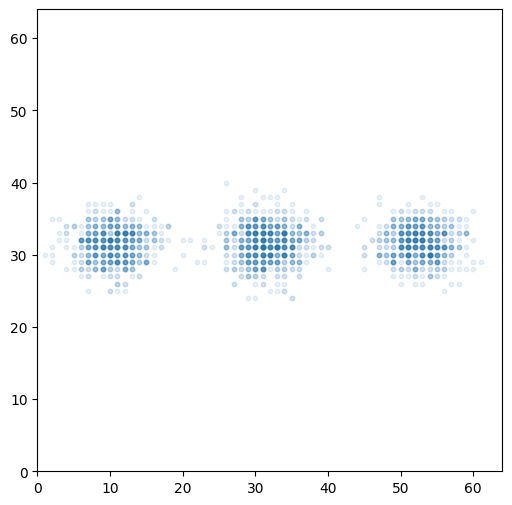

Target Reward: -0.2930627763271332
Diversity: 424


In [5]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = gaussian_mixture.generate_samples(type="1", n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.1)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
target_samples_reward = target_rewards.mean().item()
print(f"Target Reward: {target_samples_reward}")
target_samples_diversity = np.unique(target_samples, axis=0).shape[0]
print(f"Diversity: {target_samples_diversity}")

In [6]:
def intialize_particles(num_particles, device=device):
    particles = torch.full((num_particles, *input_shape), mask_index, device=device, requires_grad=False)
    return particles

# SDPO
Paper - https://arxiv.org/pdf/2507.04832

Intialize model to optimize

In [41]:
model = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
model.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))
model.eval()

MaskedDiffusion(
  (denoising_model): MLP(
    (embedding): Embedding(65, 64)
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=64, out_features=130, bias=True)
    )
  )
)

In [42]:
batch_size = 100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

C:\Users\91811\dev\MScProject\Experiments\models\discrete_diffusion\utils\schedulers.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(i / self.num_timesteps)


Epoch 1/10,  Loss: 4.224623184204102


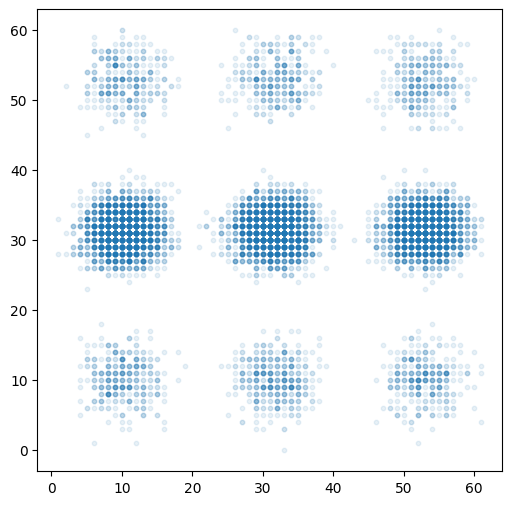

Reward: -3.8507211208343506, Diversity: 1350
Epoch 2/10,  Loss: 4.07666428565979


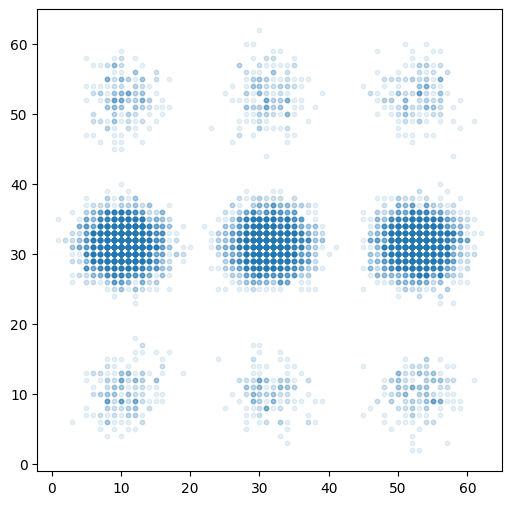

Reward: -2.131999969482422, Diversity: 1145
Epoch 3/10,  Loss: 4.127312853336334


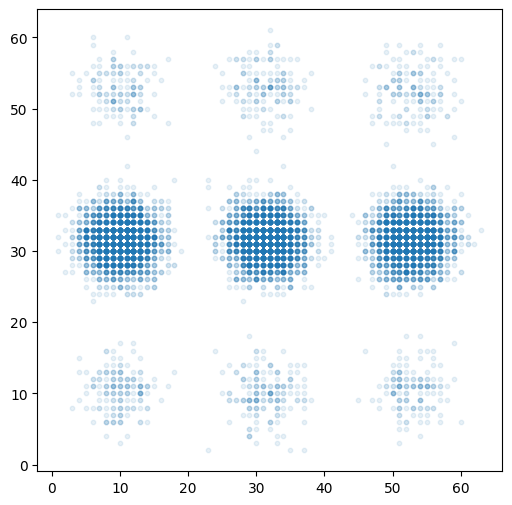

Reward: -1.8556562662124634, Diversity: 1161
Epoch 4/10,  Loss: 3.995663866996765


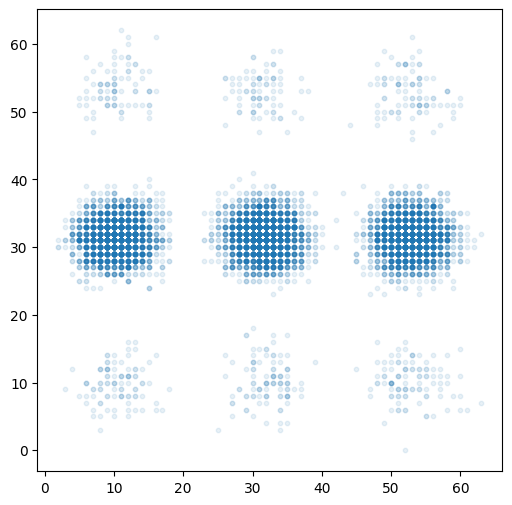

Reward: -1.3104876279830933, Diversity: 1014
Epoch 5/10,  Loss: 4.164895544052124


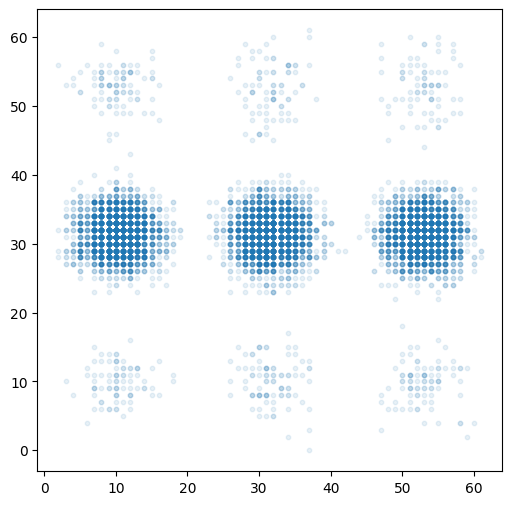

Reward: -1.2504336833953857, Diversity: 1027
Epoch 6/10,  Loss: 4.010367391109466


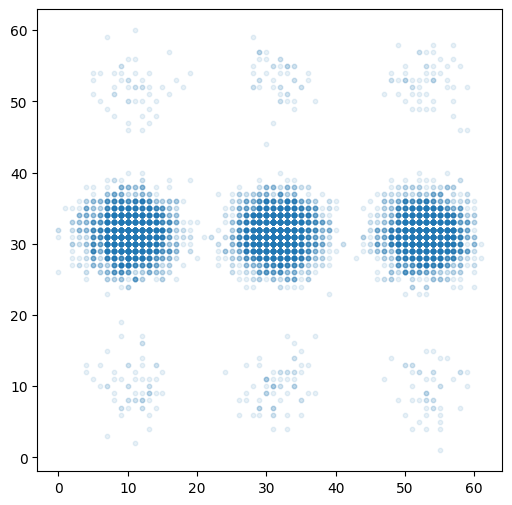

Reward: -0.9092658162117004, Diversity: 929
Epoch 7/10,  Loss: 4.067397530078888


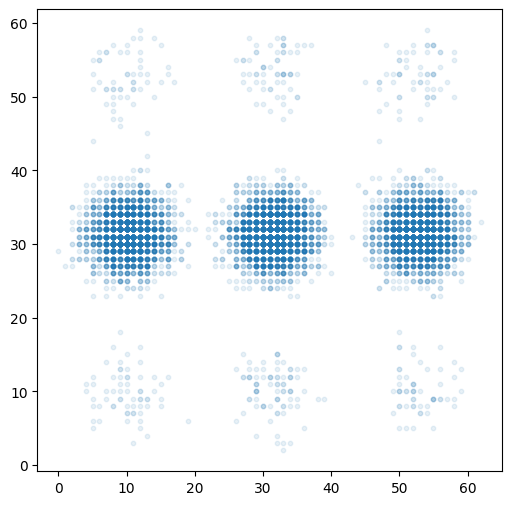

Reward: -1.0180206298828125, Diversity: 974
Epoch 8/10,  Loss: 4.002009437084198


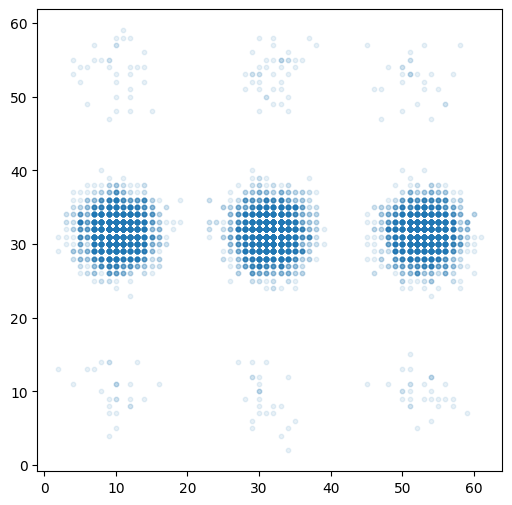

Reward: -0.6315040588378906, Diversity: 705
Epoch 9/10,  Loss: 4.030114431381225


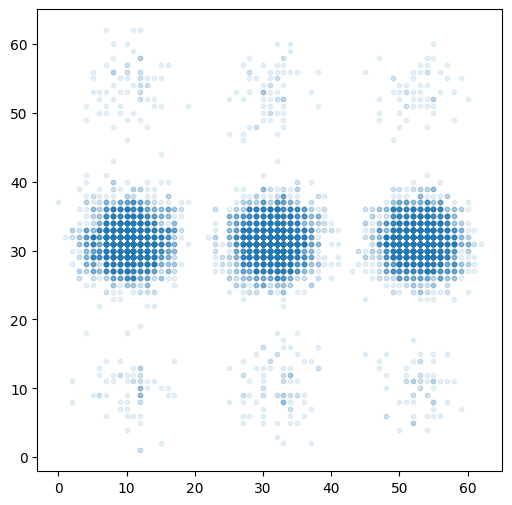

Reward: -1.071242332458496, Diversity: 1016
Epoch 10/10,  Loss: 4.137541091442108


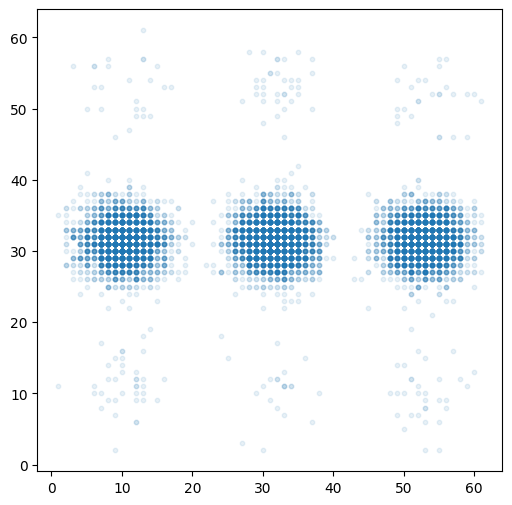

Reward: -0.6344708204269409, Diversity: 828


In [43]:
loss_trace = []
reward_trace = []

for epoch in range(num_epochs):
    total_loss, n_batches = 0.0, 0
    
    num_xt_samples_per_epoch = 100
    
    model.train()
    for batch_idx in range(num_xt_samples_per_epoch):
        optimizer.zero_grad()
        N = batch_size
        
        i = torch.randint(1, num_timesteps + 1, (1,))[0]
        t = pretrained_model.discrete_time_scheduler.discrete_time(i)
        
        xt_sample = pretrained_model.sample_till(step=i, device=device)
        
        model_x_theta = torch.distributions.Categorical(
            probs=model.get_x_theta_from_z_t(xt_sample, t).expand(N, -1, -1)
        )
        pretrained_model_x_theta = torch.distributions.Categorical(
            probs=pretrained_model.get_x_theta_from_z_t(xt_sample, t).expand(N, -1, -1)
        )
        
        x0_samples = pretrained_model_x_theta.sample()
        x0_rewards = compute_rewards(F.one_hot(x0_samples, num_classes=num_categories).float())
        
        alpha_t = pretrained_model.scheduler.alpha(t)
        beta_t = kl_weight / (1 - alpha_t)
        
        # print(f"t: {t}, alpha_t: {alpha_t}, beta_t: {beta_t}")
        
        model_rewards = beta_t * (
            model_x_theta.log_prob(x0_samples).sum(dim=1) - 
            pretrained_model_x_theta.log_prob(x0_samples).sum(dim=1)
        )
        
        loss = -1.0 * (
            F.softmax(x0_rewards, dim=0) * F.log_softmax(model_rewards, dim=0)
        ).sum(dim=0)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    model.eval()
    
    avg_loss = total_loss / n_batches
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)

    model_samples = model.sample(num_samples=10000, device=device).cpu()     
    plt.figure(figsize=(6, 6))
    plt.scatter(model_samples[:, 0], model_samples[:, 1], s=10, alpha=0.1)
    plt.show()
    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}, Diversity: {np.unique(model_samples, axis=0).shape[0]}")
    reward_trace.append(rewards.mean().item())

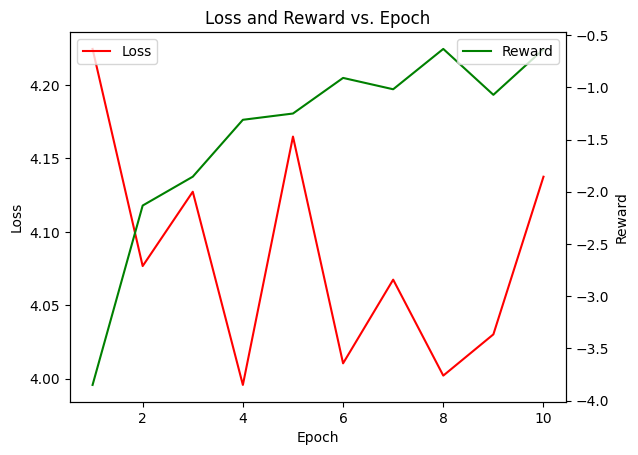

In [44]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()